In [ ]:
%%shell
jupyter nbconvert --to html ///content/Lab4_Data_Imputation.ipynb

[NbConvertApp] Converting notebook ///content/Lab4_Data_Imputation.ipynb to html
[NbConvertApp] Writing 924330 bytes to /content/Lab4_Data_Imputation.html


# Lab 4: Data Imputation using an Autoencoder


In this lab, you will build and train an autoencoder to impute (or "fill in") missing data.

We will be using the
Adult Data Set provided by the UCI Machine Learning Repository [1], available
at https://archive.ics.uci.edu/ml/datasets/adult.
The data set contains census record files of adults, including their
age, martial status, the type of work they do, and other features.

Normally, people use this data set to build a supervised classification
model to classify whether a person is a high income earner.
We will not use the dataset for this original intended purpose.

Instead, we will perform the task of imputing (or "filling in") missing values in the dataset. For example,
we may be missing one person's martial status, and another person's age, and
a third person's level of education. Our model will predict the missing features
based on the information that we do have about each person.

We will use a variation of a denoising autoencoder to solve this data imputation
problem. Our autoencoder will be trained using inputs that have one categorical feature artificially
removed, and the goal of the autoencoder is to correctly reconstruct all features,
including the one removed from the input.

In the process, you are expected to learn to:

1. Clean and process continuous and categorical data for machine learning.
2. Implement an autoencoder that takes continuous and categorical (one-hot) inputs.
3. Tune the hyperparameters of an autoencoder.
4. Use baseline models to help interpret model performance.

[1] Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.


### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.


## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link:https://colab.research.google.com/drive/1X2vPFjfgc_ptUA7U-_3pH0BOpG0TVuEt?usp=sharing

In [ ]:
import csv
import numpy as np
import random
import torch
import torch.utils.data
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

## Part 0

We will be using a package called `pandas` for this assignment.

If you are using Colab, `pandas` should already be available.
If you are using your own computer,
installation instructions for `pandas` are available here:
https://pandas.pydata.org/pandas-docs/stable/install.html

In [ ]:
import pandas as pd

# Part 1. Data Cleaning [15 pt]

The adult.data file is available at `https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data`

The function `pd.read_csv` loads the adult.data file into a pandas dataframe.
You can read about the pandas documentation for `pd.read_csv` at
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [ ]:
header = ['age', 'work', 'fnlwgt', 'edu', 'yredu', 'marriage', 'occupation',
 'relationship', 'race', 'sex', 'capgain', 'caploss', 'workhr', 'country']
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=header,
    index_col=False)

<ipython-input-97-037957db2593>:3: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df = pd.read_csv(


In [ ]:
df.shape # there are 32561 rows (records) in the data frame, and 14 columns (features)

(32561, 14)

### Part (a) Continuous Features [3 pt]

For each of the columns `["age", "yredu", "capgain", "caploss", "workhr"]`, report the minimum, maximum, and average value across the dataset.

Then, normalize each of the features `["age", "yredu", "capgain", "caploss", "workhr"]`
so that their values are always between 0 and 1.
Make sure that you are actually modifying the dataframe `df`.

Like numpy arrays and torch tensors,
pandas data frames can be sliced. For example, we can
display the first 3 rows of the data frame (3 records) below.

In [ ]:
df[:3] # show the first 3 records

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States


Alternatively, we can slice based on column names,
for example `df["race"]`, `df["hr"]`, or even index multiple columns
like below.

In [ ]:
subdf = df[["age", "yredu", "capgain", "caploss", "workhr"]]
subdf[:3] # show the first 3 records

,age,yredu,capgain,caploss,workhr
0,39,13,2174,0,40
1,50,13,0,0,13
2,38,9,0,0,40


Numpy works nicely with pandas, like below:

In [ ]:
np.sum(subdf["caploss"])

2842700

Just like numpy arrays, you can modify
entire columns of data rather than one scalar element at a time.
For example, the code  

`df["age"] = df["age"] + 1`

would increment everyone's age by 1.

In [ ]:
#this code displays the min,max and mean values
features = ["age","yredu","capgain","caploss","workhr"]
stats=  df[features].agg(["min","max","mean"])
print(stats)

            age      yredu       capgain     caploss     workhr
min   17.000000   1.000000      0.000000     0.00000   1.000000
max   90.000000  16.000000  99999.000000  4356.00000  99.000000
mean  38.581647  10.080679   1077.648844    87.30383  40.437456


In [ ]:
# this code normalizes the values
for i in features:
  min_val = df[features].min()
  max_val = df[features].max()
  df[features] = (df[features] - min_val) / (max_val - min_val)

# Display the first few rows of the normalized dataframe to verify
print(df.head())


        age               work  fnlwgt         edu     yredu  \
0  0.301370          State-gov   77516   Bachelors  0.800000   
1  0.452055   Self-emp-not-inc   83311   Bachelors  0.800000   
2  0.287671            Private  215646     HS-grad  0.533333   
3  0.493151            Private  234721        11th  0.400000   
4  0.150685            Private  338409   Bachelors  0.800000   

              marriage          occupation    relationship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   capgain  caploss    workhr         country  
0  0.02174      0.0  0.397959   United-States  
1  0.00000      0.0  0.122449   United-State

### Part (b) Categorical Features [1 pt]

What percentage of people in our data set are male? Note that the data labels all have an unfortunate space in the beginning, e.g. " Male" instead of "Male".

What percentage of people in our data set are female?

In [ ]:
# hint: you can do something like this in pandas
num_of_males= sum(df["sex"] == " Male")
num_of_females= sum(df["sex"] == " Female")

# Calculate the total number of records
total_records = df.shape[0]

# Calculate the percentages
percent_males = (num_of_males / total_records) * 100
percent_females = (num_of_females / total_records) * 100

# Display the results
print(f"Percentage of males: {percent_males:.2f}%")
print(f"Percentage of females: {percent_females:.2f}%")


Percentage of males: 66.92%
Percentage of females: 33.08%


### Part (c) [2 pt]

Before proceeding, we will modify our data frame in a couple more ways:

1. We will restrict ourselves to using a subset of the features (to simplify our autoencoder)
2. We will remove any records (rows) already containing missing values, and store them in a second dataframe. We will only use records without missing values to train our autoencoder.

Both of these steps are done for you, below.

How many records contained missing features? What percentage of records were removed?

In [ ]:
contcols = ["age", "yredu", "capgain", "caploss", "workhr"]
catcols = ["work", "marriage", "occupation", "edu", "relationship", "sex"]
features = contcols + catcols
df = df[features]

In [ ]:
missing = pd.concat([df[c] == " ?" for c in catcols], axis=1).any(axis=1)
df_with_missing = df[missing]
df_not_missing = df[~missing]

In [ ]:
# Calculate the number of records with missing features
num_missing = df_with_missing.shape[0]

# Calculate the total number of records
total_records = df.shape[0]

# Calculate the percentage of records removed
percent_removed = (num_missing / total_records) * 100

# Display the results
print(f"Number of records with missing features: {num_missing}")
print(f"Percentage of records removed: {percent_removed:.2f}%")

Number of records with missing features: 1843
Percentage of records removed: 5.66%


### Part (d) One-Hot Encoding [1 pt]

What are all the possible values of the feature "work" in `df_not_missing`? You may find the Python function `set` useful.

In [ ]:
work_values= set(df_not_missing['work'])
print(work_values)

{' Self-emp-inc', ' Private', ' Federal-gov', ' Local-gov', ' State-gov', ' Without-pay', ' Self-emp-not-inc'}


We will be using a one-hot encoding to represent each of the categorical variables.
Our autoencoder will be trained using these one-hot encodings.

We will use the pandas function `get_dummies` to produce one-hot encodings
for all of the categorical variables in `df_not_missing`.

In [ ]:
data = pd.get_dummies(df_not_missing)

In [ ]:
data[:3]

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,...,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.301370,0.800000,0.02174,0.0,0.397959,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True
1,0.452055,0.800000,0.00000,0.0,0.122449,False,False,False,False,True,...,False,False,True,False,False,False,False,False,False,True
2,0.287671,0.533333,0.00000,0.0,0.397959,False,False,True,False,False,...,False,False,False,True,False,False,False,False,False,True


### Part (e) One-Hot Encoding [2 pt]

The dataframe `data` contains the cleaned and normalized data that we will use to train our denoising autoencoder.

How many **columns** (features) are in the dataframe `data`?

Briefly explain where that number come from.

In [ ]:
num_cols= data.shape[1]
print(num_cols)

57


The number 57 represents the number of columns in "data" after applying one- got encoding. Each unique value in the category becomes a seperate binary value. For example, the unqie values of "male" and "female" under the category of "sex", get divided into it's own binary column.

### Part (f) One-Hot Conversion [3 pt]

We will convert the pandas data frame `data` into numpy, so that
it can be further converted into a PyTorch tensor.
However, in doing so, we lose the column label information that
a panda data frame automatically stores.

Complete the function `get_categorical_value` that will return
the named value of a feature given a one-hot embedding.
You may find the global variables `cat_index` and `cat_values`
useful. (Display them and figure out what they are first.)

We will need this function in the next part of the lab
to interpret our autoencoder outputs. So, the input
to our function `get_categorical_values` might not
actually be "one-hot" -- the input may instead
contain real-valued predictions from our neural network.

In [ ]:
datanp = data.values.astype(np.float32)

In [ ]:
cat_index = {}  # Mapping of feature -> start index of feature in a record
cat_values = {} # Mapping of feature -> list of categorical values the feature can take

# build up the cat_index and cat_values dictionary
for i, header in enumerate(data.keys()):
    if "_" in header: # categorical header
        feature, value = header.split()
        feature = feature[:-1] # remove the last char; it is always an underscore
        if feature not in cat_index:
            cat_index[feature] = i
            cat_values[feature] = [value]
        else:
            cat_values[feature].append(value)

def get_onehot(record, feature):
    """
    Return the portion of `record` that is the one-hot encoding
    of `feature`. For example, since the feature "work" is stored
    in the indices [5:12] in each record, calling `get_range(record, "work")`
    is equivalent to accessing `record[5:12]`.

    Args:
        - record: a numpy array representing one record, formatted
                  the same way as a row in `data.np`
        - feature: a string, should be an element of `catcols`
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    return record[start_index:stop_index]

def get_categorical_value(onehot, feature):
    """
    Return the categorical value name of a feature given
    a one-hot vector representing the feature.

    Args:
        - onehot: a numpy array one-hot representation of the feature
        - feature: a string, should be an element of `catcols`

    Examples:

    >>> get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")
    'State-gov'
    >>> get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")
    'Private'
    """
    # <----- TODO: WRITE YOUR CODE HERE ----->
    # You may find the variables `cat_index` and `cat_values`
    # (created above) useful.
    max_index = np.argmax(onehot)
    return cat_values[feature][max_index]

In [ ]:
# more useful code, used during training, that depends on the function
# you write above

def get_feature(record, feature):
    """
    Return the categorical feature value of a record
    """
    onehot = get_onehot(record, feature)
    return get_categorical_value(onehot, feature)

def get_features(record):
    """
    Return a dictionary of all categorical feature values of a record
    """
    return { f: get_feature(record, f) for f in catcols }

### Part (g) Train/Test Split [3 pt]

Randomly split the data into approximately 70% training, 15% validation and 15% test.

Report the number of items in your training, validation, and test set.

In [ ]:
# set the numpy seed for reproducibility
#"https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.seed.htm"

np.random.seed(50)
np.random.shuffle(datanp)

train_index = int(datanp.shape[0] * 0.7)
val_index = int(datanp.shape[0] * 0.85)

train_set = datanp[:train_index]
val_set = datanp[train_index:val_index]
test_set = datanp[val_index:]
print("Train Set Values: " + str(train_set.shape[0]))
print("Test Set Values: " + str(val_set.shape[0]))
print("Val Set Values: " + str(test_set.shape[0]))

Train Set Values: 21502
Test Set Values: 4608
Val Set Values: 4608


## Part 2. Model Setup [5 pt]

### Part (a) [4 pt]

Design a fully-connected autoencoder by modifying the `encoder` and `decoder`
below.

The input to this autoencoder will be the features of the `data`, with
one categorical feature recorded as "missing". The output of the autoencoder
should be the reconstruction of the same features, but with the missing
value filled in.

**Note**: Do not reduce the dimensionality of the input too much!
The output of your embedding is expected to contain information
about ~11 features.

In [ ]:
from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(57, 32), # TODO -- FILL OUT THE CODE HERE!
            nn.Linear(32,24),
            nn.Linear(24,16) #have not reduced the dimensionality too much. I have assumed that we can keep it 11 or more
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 24), # TODO -- FILL OUT THE CODE HERE!
            nn.Linear(24,32),
            nn.Linear(32,57),
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Part (b) [1 pt]

Explain why there is a sigmoid activation in the last step of the decoder.

(**Note**: the values inside the data frame `data` and the training code in Part 3 might be helpful.)

There is a sigmoid activation in the last steps which ensures that the finalized output value are between the ranges of 0 of 1.

## Part 3. Training [18]

### Part (a) [6 pt]

We will train our autoencoder in the following way:

- In each iteration, we will hide one of the categorical features using the `zero_out_random_features` function
- We will pass the data with one missing feature through the autoencoder, and obtain a reconstruction
- We will check how close the reconstruction is compared to the original data -- including the value of the missing feature

Complete the code to train the autoencoder, and plot the training and validation loss every few iterations.
You may also want to plot training and validation "accuracy" every few iterations, as we will define in
part (b). You may also want to checkpoint your model every few iterations or epochs.

Use `nn.MSELoss()` as your loss function. (Side note: you might recognize that this loss function is not
ideal for this problem, but we will use it anyway.)

In [ ]:
def zero_out_feature(records, feature):
    """ Set the feature missing in records, by setting the appropriate
    columns of records to 0
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    records[:, start_index:stop_index] = 0
    return records

def zero_out_random_feature(records):
    """ Set one random feature missing in records, by setting the
    appropriate columns of records to 0
    """
    return zero_out_feature(records, random.choice(catcols))

def train(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-4):
    """ Training loop. You should update this."""
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_acc = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)

    train_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)

    for epoch in range(num_epochs):
        total_loss = 0
        i = 0
        model.train()
        for data in train_loader:
            data_zero = zero_out_random_feature(data.clone()) # zero out one categorical feature

            recon = model(data_zero)
            loss = criterion(recon, data)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            total_loss += loss.item()
            i += 1

        train_acc[epoch] = get_accuracy(model, train_loader)
        val_acc[epoch] = get_accuracy(model, valid_loader)
        train_loss[epoch] = total_loss / (i + 1)

        # Calculate validation loss within the training function
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for j, val_data in enumerate(valid_loader):
                val_data_zero = zero_out_random_feature(val_data.clone()) # zero out one categorical feature
                recon_val = model(val_data_zero)
                val_loss_batch = criterion(recon_val, val_data)
                total_val_loss += val_loss_batch.item()

        val_loss[epoch] = total_val_loss / (j + 1)

        print("epoch: ", epoch, end = " ")
        print("train acc: ", train_acc[epoch], end = " ")
        print("val acc: ", val_acc[epoch], end = " ")
        print("train loss: ", train_loss[epoch], end = " ")
        print("val loss: ", val_loss[epoch])

    epochs = np.arange(1, num_epochs + 1)

    # Plotting training and validation losses
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Valid Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.show()

    # Plotting training and validation accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_acc, label='Train Accuracy')
    plt.plot(epochs, val_acc, label='Valid Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

    #return train_acc, val_acc, train_loss, val_loss, epochs

### Part (b) [3 pt]

While plotting training and validation loss is valuable, loss values are harder to compare
than accuracy percentages. It would be nice to have a measure of "accuracy" in this problem.

Since we will only be imputing missing categorical values, we will define an accuracy measure.
For each record and for each categorical feature, we determine whether
the model can predict the categorical feature given all the other features of the record.

A function `get_accuracy` is written for you. It is up to you to figure out how to
use the function. **You don't need to submit anything in this part.**
To earn the marks, correctly plot the training and validation accuracy every few
iterations as part of your training curve.

In [ ]:
def get_accuracy(model, data_loader):
    """Return the "accuracy" of the autoencoder model across a data set.
    That is, for each record and for each categorical feature,
    we determine whether the model can successfully predict the value
    of the categorical feature given all the other features of the
    record. The returned "accuracy" measure is the percentage of times
    that our model is successful.

    Args:
       - model: the autoencoder model, an instance of nn.Module
       - data_loader: an instance of torch.utils.data.DataLoader

    Example (to illustrate how get_accuracy is intended to be called.
             Depending on your variable naming this code might require
             modification.)

        >>> model = AutoEncoder()
        >>> vdl = torch.utils.data.DataLoader(data_valid, batch_size=256, shuffle=True)
        >>> get_accuracy(model, vdl)
    """
    total = 0
    acc = 0
    for col in catcols:
        for item in data_loader: # minibatches
            inp = item.detach().numpy()
            out = model(zero_out_feature(item.clone(), col)).detach().numpy()
            for i in range(out.shape[0]): # record in minibatch
                acc += int(get_feature(out[i], col) == get_feature(inp[i], col))
                total += 1
    return acc / total

### Part (c) [4 pt]

Run your updated training code, using reasonable initial hyperparameters.

Include your training curve in your submission.

epoch:  0 train acc:  0.4380755278578737 val acc:  0.43702980324074076 train loss:  0.15782063973940444 val loss:  0.07399866833455032
epoch:  1 train acc:  0.4590580721173224 val acc:  0.4580078125 train loss:  0.07124796511953592 val loss:  0.07067453706016143
epoch:  2 train acc:  0.45907357455120457 val acc:  0.4580078125 train loss:  0.07013842412643688 val loss:  0.07005778224103981
epoch:  3 train acc:  0.4590813257681456 val acc:  0.4580078125 train loss:  0.06943830664239227 val loss:  0.06927766050729486
epoch:  4 train acc:  0.4711577217623167 val acc:  0.46958188657407407 train loss:  0.06810545640547128 val loss:  0.06672201719548967
epoch:  5 train acc:  0.5369888072427371 val acc:  0.5377965856481481 train loss:  0.06182763443635196 val loss:  0.0573669026295344
epoch:  6 train acc:  0.5542895234551825 val acc:  0.5537832754629629 train loss:  0.05582081862567794 val loss:  0.055059606157657176
epoch:  7 train acc:  0.560335472669209 val acc:  0.5599320023148148 train lo

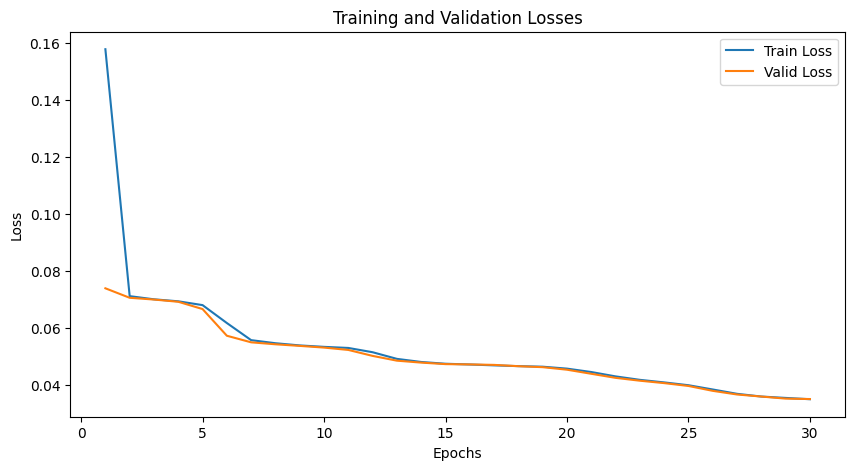

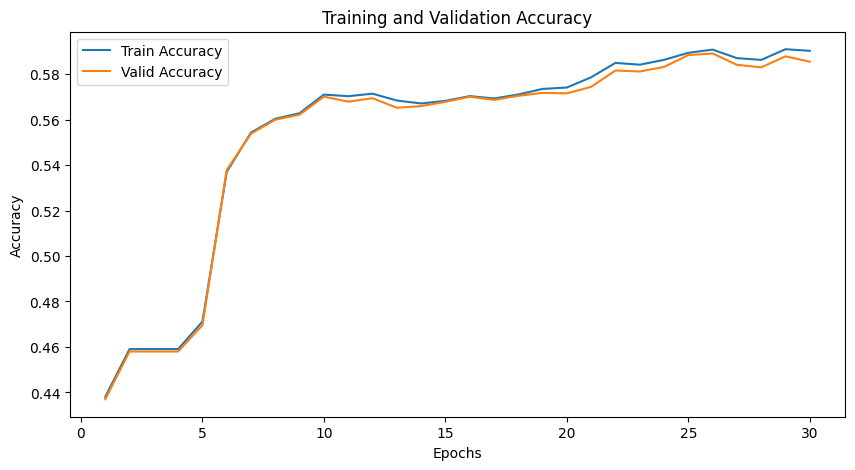

In [ ]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, num_workers=1)
valid_loader = torch.utils.data.DataLoader(val_set, batch_size=64, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, num_workers=1)
autoencoder_A = AutoEncoder()
train(autoencoder_A, train_loader, valid_loader, num_epochs=30, learning_rate=1e-4)

### Part (d) [5 pt]

Tune your hyperparameters, training at least 4 different models (4 sets of hyperparameters).

Do not include all your training curves. Instead, explain what hyperparameters
you tried, what their effect was, and what your thought process was as you
chose the next set of hyperparameters to try.

In [ ]:
#hyp_tuning_1= AutoEncoder()
#train(hyp_tuning_1, train_loader, valid_loader, num_epochs=40, learning_rate=1e-4)
#the number of epochs was increased from 30 to 40. All the other hyperparameter settings remained the same, batch_size=64 and learning_rate=1e-4.
# Results: Validation Accuracy: 58.8% and Training Accuracy: 59.04%, Training Loss: 0.03 and Validation Loss: 0.034

#hyp_tuning_2= AutoEncoder()
#train(hyp_tuning_2, train_loader, valid_loader, num_epochs=40, learning_rate=1e-5)
#the number of epochs was kept 40, as it resulted in better validation accuracies. The learning rate is reduced to 1e-5, to observe if a lower
#learning rate leads to better validation accuracies.
#Results: Validation Accuracy: 49.8%, Training Accuracy: 49.9%, Training Loss= 0.06, Validation Loss= 0.061. It is important to note how the
#training accuracies have gotten significantly worse, so in the next model, I would like to observe the results of increasing the learning rate.

#hyp_tuning_3= AutoEncoder()
#train(hyp_tuning_3, train_loader, valid_loader, num_epochs=50, learning_rate=1e-3)
#In this model I have increased the num_epochs to 50 and the learning_rate=1e-3.
#Results: Validation Accuracy: 59.8%, Training Accuracy: 60.3%, Training Loss= 0.0191, Validation Loss= 0.02. The increase in the
#learning rate also led to a very noisy graph for Validation and Training Accuracies.

#hyp_tuning_4= AutoEncoder()
#train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, num_workers=1)
#valid_loader = torch.utils.data.DataLoader(val_set, batch_size=32, num_workers=1)
#train(hyp_tuning_4, train_loader, valid_loader, num_epochs=40, learning_rate=1e-4)
#In this model, I reduced the batch_sizes to 32 and kept num_epochs=40 and switched the learning_rate back to 1e-4 as it provided a better result previously.
#Results: Validation Accuracy: 59.7%, Training Accuracy: 60.1%, Training Loss= 0.0264, Validation Loss= 0.027027

epoch:  0 train acc:  0.5633817009270455 val acc:  0.5618851273148148 train loss:  0.07667285341006712 val loss:  0.053138880162603326
epoch:  1 train acc:  0.5644281152140886 val acc:  0.5650318287037037 train loss:  0.04762996286595964 val loss:  0.042560561611834496
epoch:  2 train acc:  0.5899761262518215 val acc:  0.5881799768518519 train loss:  0.03951562235258984 val loss:  0.03646428145778676
epoch:  3 train acc:  0.5864880786283446 val acc:  0.5864438657407407 train loss:  0.0357580058144002 val loss:  0.03472840840307375
epoch:  4 train acc:  0.5986729916596906 val acc:  0.595703125 train loss:  0.03347400400665995 val loss:  0.03194429909086062
epoch:  5 train acc:  0.5911388087929805 val acc:  0.5891565393518519 train loss:  0.03092171438038349 val loss:  0.030644760182541277
epoch:  6 train acc:  0.5986109819241621 val acc:  0.5926649305555556 train loss:  0.02941872451443347 val loss:  0.028285969695490267
epoch:  7 train acc:  0.5956035097510309 val acc:  0.5903862847222

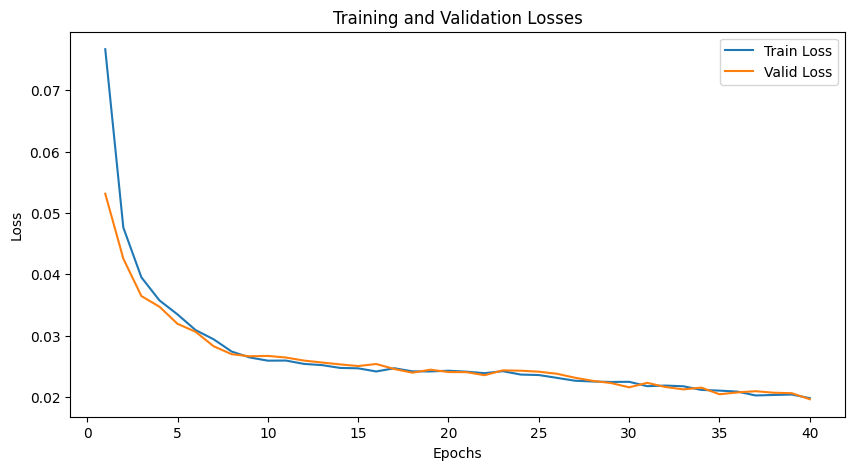

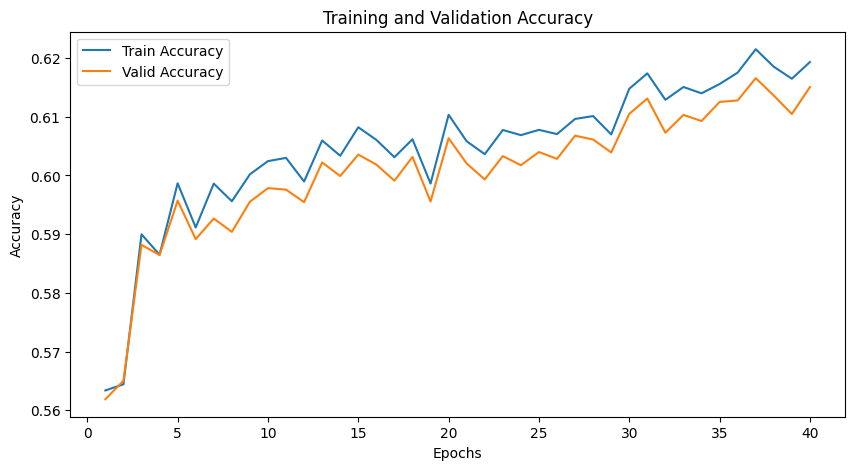

In [ ]:
#Now printing out the results of the best model
hyp_tuning_2= AutoEncoder()
train(hyp_tuning_2, train_loader, valid_loader, num_epochs=40, learning_rate=1e-3)

## Part 4. Testing [12 pt]

### Part (a) [2 pt]

Compute and report the test accuracy.

In [ ]:
test_accuracy= get_accuracy(hyp_tuning_2,test_loader)
print(test_accuracy * 100)

61.704282407407405


Therefore, it can be seen that the test_set reports around 61.7% accuracy.

### Part (b) [4 pt]

Based on the test accuracy alone, it is difficult to assess whether our model
is actually performing well. We don't know whether a high accuracy is due to
the simplicity of the problem, or if a poor accuracy is a result of the inherent
difficulty of the problem.

It is therefore very important to be able to compare our model to at least one
alternative. In particular, we consider a simple **baseline**
model that is not very computationally expensive. Our neural network
should at least outperform this baseline model. If our network is not much
better than the baseline, then it is not doing well.

For our data imputation problem, consider the following baseline model:
to predict a missing feature, the baseline model will look at the **most common value** of the feature in the training set.

For example, if the feature "marriage" is missing, then this model's prediction will be the most common value for "marriage" in the training set, which happens to be "Married-civ-spouse".

What would be the test accuracy of this baseline model?


In [ ]:
most_common = {col: df_not_missing[col].mode().item() for col in df_not_missing.columns}
# Print each key-value pair on a new line
for key, value in most_common.items():
    print(f"{key}: {value}")
print("")
total_accuracy = 0
for col in df_not_missing.columns:
    baseline_acc = sum(df_not_missing[col] == baseline[col]) / len(df_not_missing)
    total_accuracy += baseline_acc

    print(f"The baseline model accuracy of the \"{col}\" feature is: {baseline_acc * 100:.2f}%")

# Calculate overall baseline accuracy
overall_accuracy = total_accuracy / len(df_not_missing.columns) #basically calculating the mean
print(f"\nThe overall baseline model accuracy across all features is: {overall_accuracy * 100:.2f}%")

age: 0.2602739726027397
yredu: 0.5333333333333333
capgain: 0.0
caploss: 0.0
workhr: 0.3979591836734694
work:  Private
marriage:  Married-civ-spouse
occupation:  Prof-specialty
edu:  HS-grad
relationship:  Husband
sex:  Male

The baseline model accuracy of the "age" feature is: 2.85%
The baseline model accuracy of the "yredu" feature is: 32.45%
The baseline model accuracy of the "capgain" feature is: 91.57%
The baseline model accuracy of the "caploss" feature is: 95.24%
The baseline model accuracy of the "workhr" feature is: 47.28%
The baseline model accuracy of the "work" feature is: 73.89%
The baseline model accuracy of the "marriage" feature is: 46.68%
The baseline model accuracy of the "occupation" feature is: 13.48%
The baseline model accuracy of the "edu" feature is: 32.45%
The baseline model accuracy of the "relationship" feature is: 41.36%
The baseline model accuracy of the "sex" feature is: 67.67%

The overall baseline model accuracy across all features is: 49.54%


### Part (c) [1 pt]

How does your test accuracy from part (a) compared to your basline test accuracy in part (b)?

The overall accuracy of the baseline model was around **49.54%**, whereas the accuracy from the model in part a) was around **61.7%.**

### Part (d) [1 pt]

Look at the first item in your test data.
Do you think it is reasonable for a human
to be able to guess this person's education level
based on their other features? Explain.

In [ ]:
get_features(test_set[0])

{'work': 'Private',
 'marriage': 'Divorced',
 'occupation': 'Prof-specialty',
 'edu': 'Bachelors',
 'relationship': 'Not-in-family',
 'sex': 'Male'}

No, it is not possible for a human to be able to guess a person's education level based on other features. For example, a feature like 'Not-in-family', would not provide much insight into what education this individual has achieved.

### Part (e) [2 pt]

What is your model's prediction of this person's education
level, given their other features?


In [ ]:
#convert the test_set into a tensor
test_tensor= torch.tensor(test_set[0]).view(1, -1) #reshaping to a 1 row tensor
#to achieve the zeroed out "edu" feature
zero_edu = zero_out_feature(test_tensor, "edu")
# do the model prediction using the best model after hyperparameter tuning, which was hyp_tuning_2
model_prediction = hyp_tuning_2(zero_edu).detach().numpy() #converting to a numpy array
predicted_edu = get_feature(model_prediction[0], "edu")
print("Model predicted education level:", predicted_edu)

Model predicted education level: Assoc-acdm


My model predicts an education of Assoc-acdm, but it does not accurately match with the correct prediction- "Bachelors".

### Part (f) [2 pt]

What is the baseline model's prediction
of this person's education level?

In [ ]:
def predict_baseline_education_level(baseline, test_data, feature_to_predict):
    return baseline[feature_to_predict]

#output the baseline model estimate
baseline_prediction = predict_baseline_education_level(baseline, test_set[0], "edu")
print(baseline_prediction)

 HS-grad


The baseline model predicts the education of a HS grad, and this also does not match with the correct prediction of Bachelors.